# Setup Config
- In this notebook file, we try MPI and Domain Decomposition from JutulDarcy

In [1]:
VERSION

v"1.9.4"

In [2]:
Threads.nthreads()

1

In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `C:\Users\D2A2\JutulDarcyRules_ME_Grant\src`


In [4]:
Pkg.status()

Status `C:\Users\D2A2\JutulDarcyRules_ME_Grant\src\Project.toml`
  [7d9fca2a] Arpack v0.5.4
  [d360d2e6] ChainRulesCore v1.25.1
⌅ [587475ba] Flux v0.14.21
  [e9467ef8] GLMakie v0.11.2
  [1ecd5474] GraphMakie v0.5.13
⌅ [b5ffcf37] HYPRE v1.6.0
  [2b460a1a] Jutul v0.3.6
  [82210473] JutulDarcy v0.2.41
  [41f0c4f5] JutulDarcyRules v0.3.0 `..\..\JutulDarcyRules_alt.jl`
  [f4a74d36] LayeredLayouts v0.2.10
  [46757867] NetworkLayout v0.4.9
  [429524aa] Optim v1.11.0
⌅ [08abe8d2] PrettyTables v2.2.3
  [0448d7d9] RandomizedLinAlg v0.1.0
  [8ba89e20] Distributed
  [37e2e46d] LinearAlgebra
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


# Load Grant's Version of JutulDarcyRules

I installed it as JutulDarcyRules_alt

In [4]:
pwd()

"C:\\Users\\D2A2\\JutulDarcyRules_ME_Grant\\src"

In [4]:
Pkg.status("JutulDarcyRules")

Status `C:\Users\D2A2\JutulDarcyRules_ME_Grant\src\Project.toml`
  [41f0c4f5] JutulDarcyRules v0.3.0 `..\..\JutulDarcyRules_alt.jl`


# Run single forward Simulation

In [2]:
using JutulDarcyRules

In [3]:
using LinearAlgebra
using PyPlot
using JLD2

In [4]:
using Printf
using Statistics: mean, std
using Distributions
using Zygote

## Load Dataset

In [5]:
JLD2.@load "../../Diff_MultiPhysics/FNO-NF.jl/scripts/wise_perm_models_2000_new.jld2" #phi = porosity

4-element Vector{Symbol}:
 :K
 :phi
 :BroadK
 :NarrowK

In [25]:
## grid size
# dx = 128
# dy = 128
# n = (dx, 1, dy)
# d = (15.0, 10.0, 15.0) # in meters

dx = 256
dy = 256
n = (dx, 1, dy)
d = (15.0, 10.0, 15.0) # in meters

# rescale permeability
BroadK_rescaled = BroadK[:, 1:dx, 256-dy+1:256]

## permeability
K = md * BroadK_rescaled
print(size(K))

ϕ = 0.25
model = jutulModel(n, d, ϕ, K1to3(K[1,:,:])) #-- updated! from vec(ϕ) to ϕ--#

## simulation time steppings
tstep = 100 * ones(10) #in days
tot_time = sum(tstep)

(2000, 256, 256)

1000.0

In [7]:
## injection & production
# 256 x 128: inj_loc = (120, 1, 80) .* d
# 128 x 128: inj_loc = (70, 1, 85) .* d
# 64 x 64: inj_loc = (30, 1, 45) .* d
# 80 x 80: inj_loc = (50, 1, 50) .* d
# 100 x 100: inj_loc = (60, 1, 60) .* d
# 120 x 120: inj_loc = (60, 1, 60) .* d but at first I tried 120, 120

inj_loc = (130, 1, 205) .* d
irate = 5e-3
q = jutulSource(irate, [inj_loc]) # injection
# set up modeling operator
S = jutulModeling(model, tstep)

jutulModeling{3, Float64}(jutulModel{3, Float64}((256, 1, 256), (15.0, 10.0, 15.0), [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25  …  0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25], [1.3092076858561217e-18 1.3092076858561217e-18 … 1.13878536153775e-12 1.0881861477994696e-12; 1.3092076858561217e-18 1.3092076858561217e-18 … 1.13878536153775e-12 1.0881861477994696e-12; 1.3092076858561217e-18 1.3092076858561217e-18 … 1.13878536153775e-12 1.0881861477994696e-12], 0.0, true), [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0])

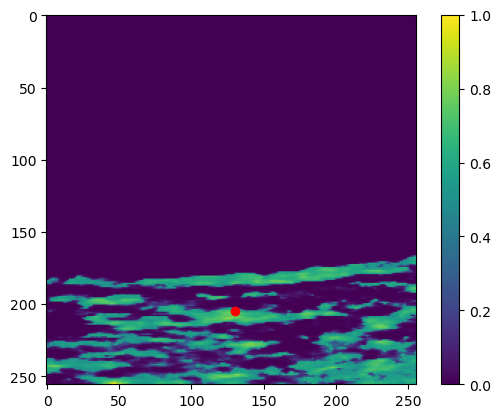

PyObject <matplotlib.colorbar.Colorbar object at 0x000001C64A7A2870>

In [8]:
imshow(K[1,:,:]')
scatter(130, 205, color="red")
colorbar()

# Define Forward Model, S

In [8]:
perm = deepcopy(K[1,:,:])
print(size(perm))
Trans = KtoTrans(CartesianMesh(model), K1to3(perm))
@time result = S(log.(Trans), q)

(256, 256)195.039400 seconds (78.90 M allocations: 87.860 GiB, 1.50% gc time, 16.04% compilation time: 1% of which was recompilation)


SimResult with 10 entries:

  states (model variables)
    :PhaseMassMobilities => Matrix{Float64} of size (2, 65536)
    :PhaseMassDensities => Matrix{Float64} of size (2, 65536)
    :RelativePermeabilities => Matrix{Float64} of size (2, 65536)
    :Saturations => Matrix{Float64} of size (2, 65536)
    :Pressure => Vector{Float64} of size (65536,)
    :TotalMasses => Matrix{Float64} of size (2, 65536)
    :PhaseMobilities => Matrix{Float64} of size (2, 65536)

  reports (timing/debug information)
    :ministeps => Vector{Any} of size (6,)
    :total_time => Float64
    :output_time => Float64

  Completed at Feb. 20 2025 1:02 after 2 minutes, 46 seconds, 479.9 milliseconds.

(65536,)

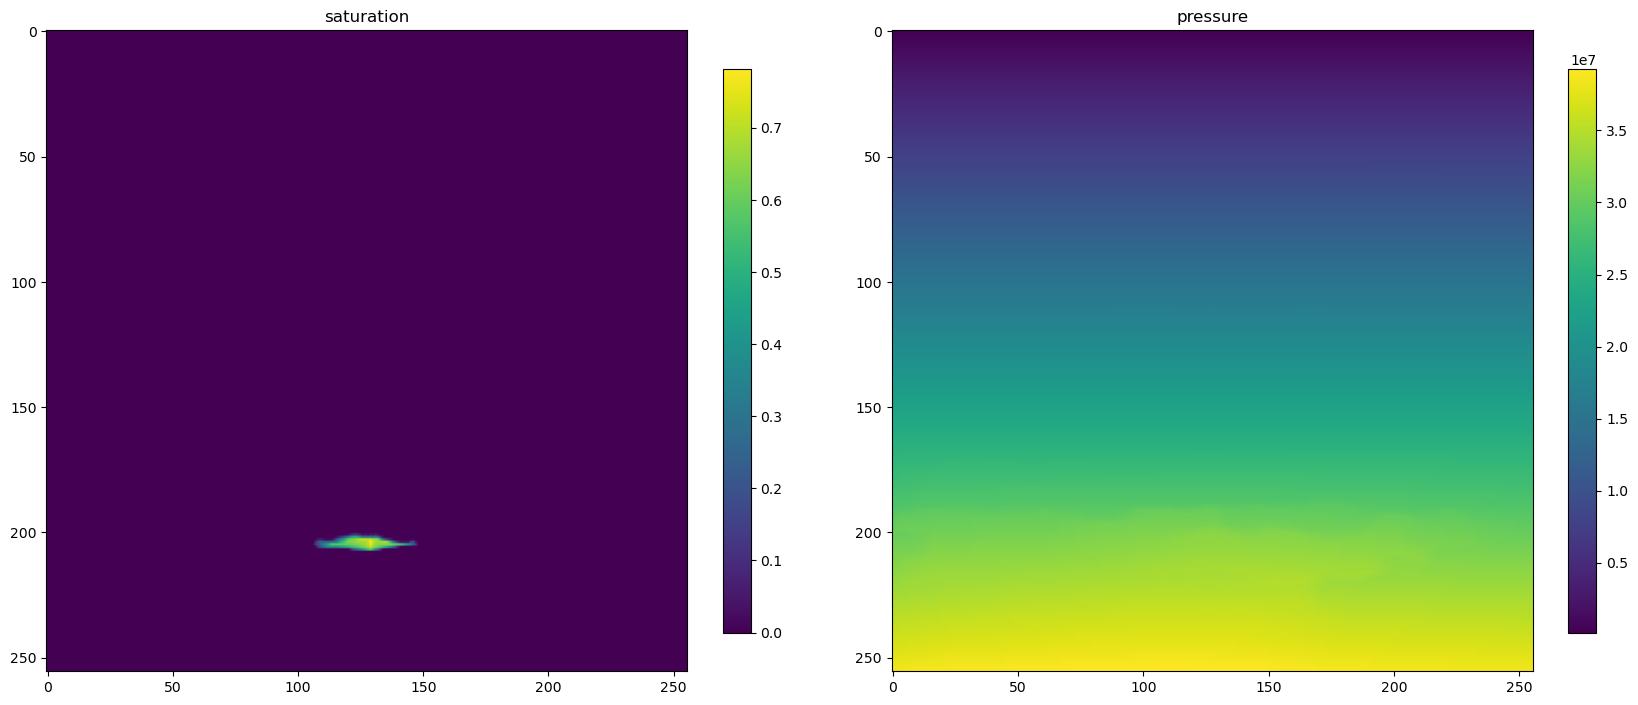

PyObject Text(0.5, 1.0, 'pressure')

In [10]:
i = 1
fig = figure(figsize=(20,12))

ax1 = subplot(1,2,1)
im1 = imshow(reshape(Saturations(result.states[i]), n[1], n[end])');  title("saturation")
colorbar(im1, ax=ax1, fraction=0.04)
title("saturation")

ax2 = subplot(1,2,2)
print(size(result.states[i][:Pressure]))
im2 = imshow(reshape(result.states[i][:Pressure], n[1], n[end])')
colorbar(im2, ax=ax2, fraction=0.04)
title("pressure")


(65536,)

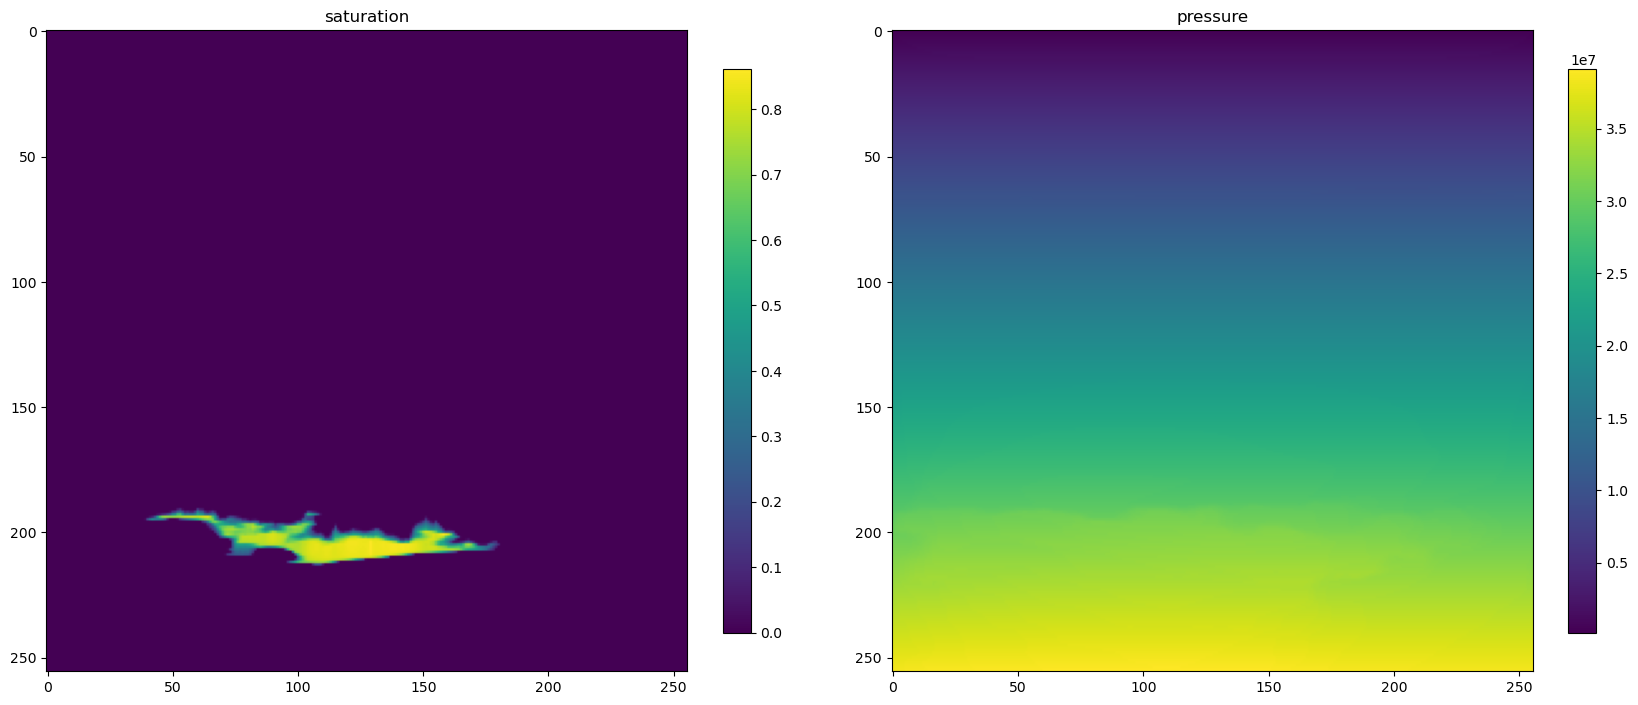

PyObject Text(0.5, 1.0, 'pressure')

In [11]:
## plotting
i = 10
fig = figure(figsize=(20,12))

ax1 = subplot(1,2,1)
im1 = imshow(reshape(Saturations(result.states[i]), n[1], n[end])');  title("saturation")
colorbar(im1, ax=ax1, fraction=0.04)
title("saturation")

ax2 = subplot(1,2,2)
print(size(result.states[i][:Pressure]))
im2 = imshow(reshape(result.states[i][:Pressure], n[1], n[end])')
colorbar(im2, ax=ax2, fraction=0.04)
title("pressure")

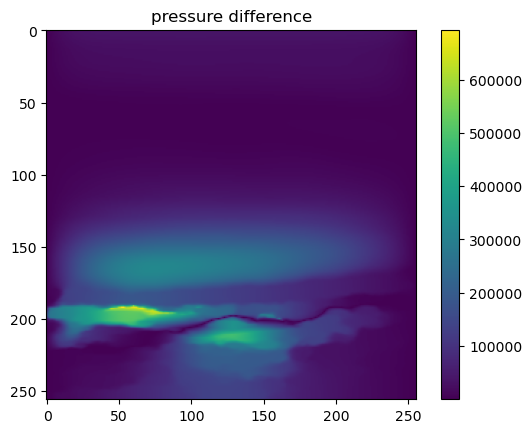

PyObject Text(0.5, 1.0, 'pressure difference')

In [12]:
first_pressure = reshape(result.states[1][:Pressure], n[1], n[end])'
last_pressure = reshape(result.states[end][:Pressure], n[1], n[end])'
diff_pressure = last_pressure - first_pressure

imshow(abs.(diff_pressure))
colorbar()
title("pressure difference")

# Parameter setting for Fisher Information Computation

In [9]:
nsample = 1
nobs = 1
# # Number of eigenvalues and eigenvectors to compute
nev = 1
tstep = 100 * ones(1) #in days
nt = length(tstep)
μ = 0.0   # Mean of the noise
σ = 1.0   # Standard deviation of the noise

dist = Normal(μ, σ)

Normal{Float64}(μ=0.0, σ=1.0)

# FIM in scalable form

In [138]:
println("State0 Keys: ", keys(state_K))

State0 Keys: (:state, :report)


In [142]:
println("State0 Keys: ", keys(state_K[:state]))

State0 Keys: [:PhaseMassMobilities, :PhaseMassDensities, :RelativePermeabilities, :Saturations, :Pressure, :TotalMasses, :PhaseMobilities]


In [165]:
println("State0 Keys: ", size(Saturations(state_K[:state])))

State0 Keys: (16384,)


In [10]:
model = jutulModel(n, d, ϕ, K1to3(K))
S = jutulModeling(model, tstep)

mesh = CartesianMesh(model)
T(x) = KtoTrans(mesh, K1to3(x))

state(x) = S(log.(T(x)), q, info_level=1)[1]

state (generic function with 1 method)

In [11]:
state_K = state(K)

LoadError: DimensionMismatch: new dimensions (256, 1, 256) must be consistent with array size 131072000

In [17]:
using Profile

In [12]:
state_sat(x) = Saturations(state(x)[:state])
cur_sample = Saturations(state_K[:state])

noise = rand(dist, size(cur_sample))
print("noise", size(noise))

# 2-1. compute log likelihood
ll(x) = norm(vec(cur_sample+noise) - state_sat(x))^2 / (2 * σ^2) 
print("computing gradient... ", size(vec(K)))
# 2-2. compute gradient
Profile.clear()
@time @profile outer_vector = Zygote.gradient((x)->ll(x), vec(K))[1]

LoadError: UndefVarError: `state_K` not defined

In [202]:
JutulDarcyRules.visCO2

0.0001

In [10]:
outer_vector = Zygote.gradient((x)->ll(x), vec(K))[1]

LoadError: UndefVarError: `ll` not defined

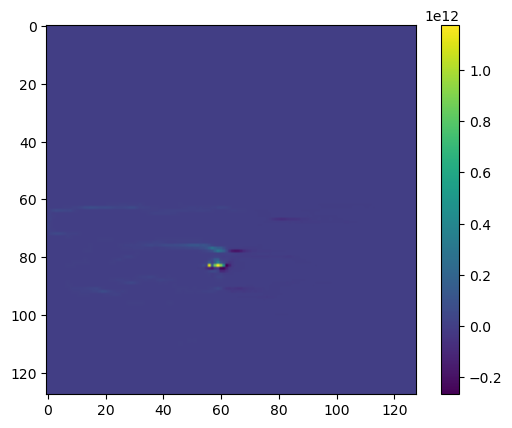

PyObject <matplotlib.colorbar.Colorbar object at 0x0000020203C47D70>

In [30]:
imshow(reshape(outer_vector, n[1], n[end])')
# scatter(60, 85, color="red")
colorbar()

### Need to fix the rest ...........

- Zygote is not multithreading safe
- Zygote pullback shares memory across threads. 

## Use multi-threading for forward process only

- Cannot use Zygote.gradient in multi-threading

## with Distributed.jl

In [26]:
using Distributed, Zygote, Random, LinearAlgebra, Distributions  # Load Distributions in main process

addprocs(2)  # Leave 1 core for the main process
println("num procs: ", nprocs())  # Check total number of processes (should be CPU_THREADS)

K = K[1,:,:]

# Load packages on all workers
@everywhere using Zygote, Random, LinearAlgebra, Distributions, JutulDarcyRules  

# @everywhere const K = $K  # Send K to all workers

# Define function on all workers
@everywhere function compute_gradient(j, cur_state_sat, state_sat, dist, σ, K)
    println("perturbation $(j)")
    noise = rand(dist, size(cur_state_sat))
    noise ./= (maximum(abs.(noise)) * 2.0)

    perturbed_input = vec(cur_state_sat + noise)

    ll(x) = norm(perturbed_input - state_sat(x))^2 / (2 * σ^2)
    # dll(x) = 2 * (perturbed_input - state_sat(x))

    outer_vector = nothing
    try
        outer_vector = Zygote.gradient((x) -> ll(x), vec(K))[1]
    catch e
        println("Gradient computation failed for perturbation $(j): ", e)
        outer_vector = zeros(length(vec(K)))  # Assign zeros on failure
    end

    println("outvec", j)
    return outer_vector
end

# Define function for parallel computation
@everywhere function compute_pullback(Fp, col_U)
    try
        return Fp(col_U)[1]
    catch e
        println("Pullback computation failed: ", e)
        return zeros(length(col_U))  # Return zeros on failure
    end
end


Ks = zeros(n[1], n[end], nsample)
eigvec_save = zeros(n[1], n[end], nev, 8)
one_Jvs = zeros(n[1]*n[end], nev, 8)
conc = zeros(n[1], n[end], 1)

for i = 1:nsample  # Loop over samples
    println("sample $(i)")
    model = jutulModel(n, d, ϕ, K1to3(K))
    S = jutulModeling(model, tstep)

    mesh = CartesianMesh(model)
    T(x) = KtoTrans(mesh, K1to3(x))
    @time state0 = S(log.(T(K)), q)[1]

    states = []

    for time_step in 1:8
        println("--------------- time step $(time_step) ---------------")
        state(x) = S(log.(T(x)), q, info_level=1)[1]
        @time state_sat(x) = Saturations(state(x)[:state])
        @time pressure(x) = state(x)[:state][:Pressure]

        state0_temp = deepcopy(state0)
        cur_state = state(K) 
        cur_state_sat = Saturations(cur_state[:state])

        state0_temp[:state][:Saturations] = cur_state_sat
        state0_temp[:state][:Pressure] = pressure(K)
        push!(states, cur_state)

        dll = zeros(n[1]*n[end], nev)

        # Run gradient computations in parallel using Distributed.jl
        gradient_results = pmap(j -> compute_gradient(j, cur_state_sat, state_sat, dist, σ, K), 1:nobs)

        # Store results in dll
        temp = hcat(gradient_results...)
        println("size temp", size(temp))
        dll .= temp

        println("All gradient computations completed, moving to pullback")

        println("before svd")
        println("Min value:", minimum(dll))
        println("Max value:", maximum(dll))
        @time U_svd, S_svd, VT_svd = LinearAlgebra.svd(dll)
        println("shape of U (left singular vectors)", size(U_svd))
        eigvec_save[:, :, :, time_step] = reshape(U_svd, n[1], n[end], nev)

        # Compute the pullback function
        Fv, Fp = Zygote.pullback(state_sat, vec(K))
        
        # Parallelize over `e` using `pmap`
        Jv_results = pmap(e -> compute_pullback(Fp, U_svd[:, e]), 1:nev)
        
        # Store results
        for e in 1:nev
            println("size lsv", size(U_svd[:, e]))
            println("size", size(Jv_results[e]))
            one_Jvs[:, e, time_step] = Jv_results[e]
        end
        state0 = deepcopy(state0_temp)
    end
end


num procs: 5
sample 1
163.307398 seconds (26.88 M allocations: 84.685 GiB, 0.92% gc time, 0.02% compilation time: 47% of which was recompilation)
--------------- time step 1 ---------------
  0.000058 seconds (23 allocations: 1.491 KiB)
  0.000008 seconds (9 allocations: 416 bytes)
Jutul: Simulating 2 years, 38.5 weeks as 10 report steps
Step  1/10: Solving start to 14 weeks, 2 days, Δt = 14 weeks, 2 days 
Convergence: Report step 1, mini-step #1 (14 weeks, 2 days) failed to converge. Reducing mini-step.
Convergence: Report step 1, mini-step #2 (7 weeks, 1 day) failed to converge. Reducing mini-step.
Convergence: Report step 1, mini-step #4 (10 weeks, 5 days) failed to converge. Reducing mini-step.
Step  2/10: Solving 14 weeks, 2 days to 28 weeks, 4 days, Δt = 14 weeks, 2 days 
Convergence: Report step 2, mini-step #1 (14 weeks, 2 days) failed to converge. Reducing mini-step.
Step  3/10: Solving 28 weeks, 4 days to 42 weeks, 6 days, Δt = 14 weeks, 2 days 
Convergence: Report step 3, mi

LoadError: On worker 2:
UndefVarError: `#state_sat` not defined
Stacktrace:
  [1] [0m[1mdeserialize_datatype[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:1385[24m[39m
  [2] [0m[1mhandle_deserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:869[24m[39m
  [3] [0m[1mdeserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:816[24m[39m
  [4] [0m[1mhandle_deserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:876[24m[39m
  [5] [0m[1mdeserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:816[24m[39m[90m [inlined][39m
  [6] [0m[1mdeserialize_global_from_main[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mclusterserialize.jl:160[24m[39m
  [7] [0m[1m#5[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mclusterserialize.jl:72[24m[39m[90m [inlined][39m
  [8] [0m[1mforeach[22m
[90m    @[39m [90m.\[39m[90m[4mabstractarray.jl:3075[24m[39m
  [9] [0m[1mdeserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mclusterserialize.jl:72[24m[39m
 [10] [0m[1mhandle_deserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:962[24m[39m
 [11] [0m[1mdeserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:816[24m[39m
 [12] [0m[1mdeserialize_datatype[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:0[24m[39m
 [13] [0m[1mhandle_deserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:871[24m[39m
 [14] [0m[1mdeserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:816[24m[39m
 [15] [0m[1mhandle_deserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:876[24m[39m
 [16] [0m[1mdeserialize[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Serialization\src\[39m[90m[4mSerialization.jl:816[24m[39m[90m [inlined][39m
 [17] [0m[1mdeserialize_msg[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mmessages.jl:87[24m[39m
 [18] [0m[1m#invokelatest#2[22m
[90m    @[39m [90m.\[39m[90m[4messentials.jl:819[24m[39m[90m [inlined][39m
 [19] [0m[1minvokelatest[22m
[90m    @[39m [90m.\[39m[90m[4messentials.jl:816[24m[39m[90m [inlined][39m
 [20] [0m[1mmessage_handler_loop[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mprocess_messages.jl:176[24m[39m
 [21] [0m[1mprocess_tcp_streams[22m
[90m    @[39m [90mC:\Users\D2A2\AppData\Local\Programs\Julia-1.9.4\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mprocess_messages.jl:133[24m[39m
 [22] [0m[1m#103[22m
[90m    @[39m [90m.\[39m[90m[4mtask.jl:514[24m[39m

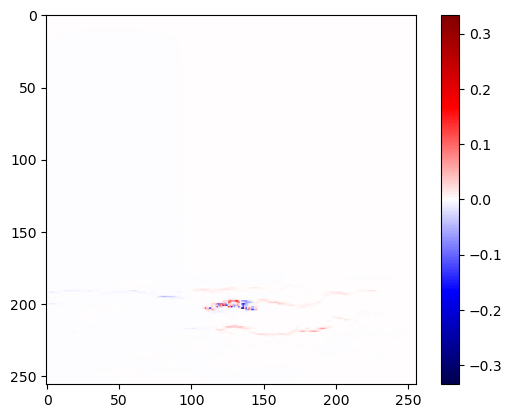

PyObject <matplotlib.colorbar.Colorbar object at 0x000002216B7CA480>

In [20]:
imshow(eigvec_save[:,:,1,1]', cmap="seismic", norm=matplotlib.colors.CenteredNorm())
colorbar()

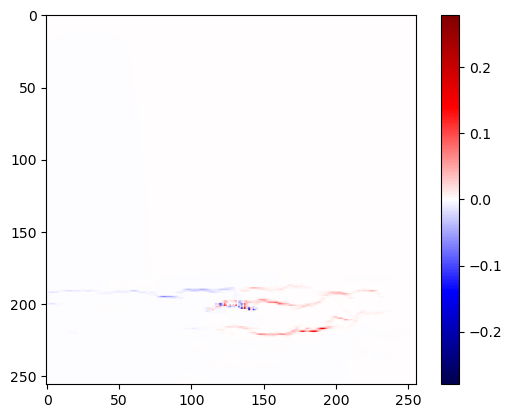

PyObject <matplotlib.colorbar.Colorbar object at 0x00000221DC10CB60>

In [21]:
imshow(eigvec_save[:,:,1,8]', cmap="seismic", norm=matplotlib.colors.CenteredNorm())
colorbar()

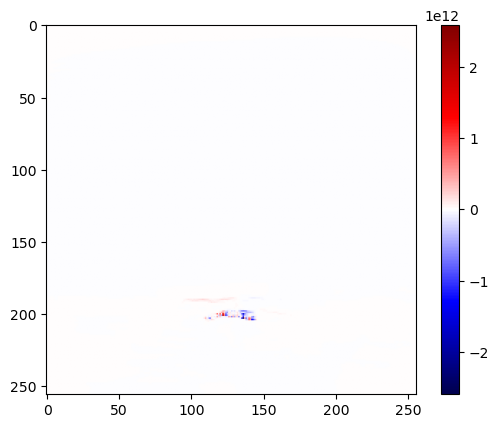

PyObject <matplotlib.colorbar.Colorbar object at 0x000002227007FFE0>

In [22]:
# The order in the third index is flipped 
# imshow(reshape(one_Jvs[:,1,1], n[1], n[end])')
imshow(reshape(one_Jvs[:,1,1], n[1], n[end])', cmap="seismic", norm=matplotlib.colors.CenteredNorm())
colorbar()

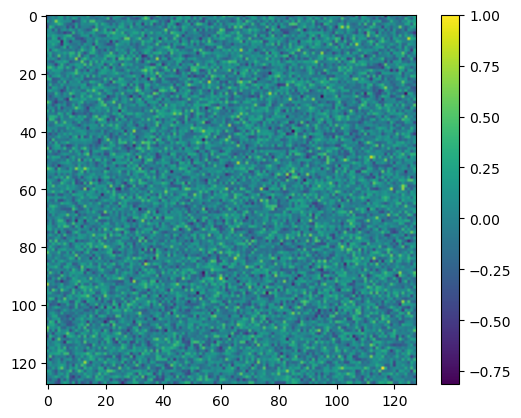

PyObject <matplotlib.colorbar.Colorbar object at 0x000002019265FD70>

In [71]:
noise = rand(dist, size(K))
max_abs = maximum(abs.(noise))
noise ./= max_abs

imshow(noise')
colorbar()

In [23]:
imshow(reshape(Saturations(state_K[:state]), n[1], n[3])')
colorbar()

LoadError: UndefVarError: `state_K` not defined

In [57]:
state_K

(state = Dict{Symbol, Any}(:PhaseMassMobilities => [0.0 0.0 … 0.0 0.0; 999851.6260000406 999851.6408358562 … 1.0000421018796575e6 1.0000420953495391e6], :PhaseMassDensities => [689.6897330360914 689.690756399655 … 702.9532819809092 702.9528229635606; 999.8516260000406 999.8516408358562 … 1000.0421018796575 1000.0420953495391], :RelativePermeabilities => [0.0 0.0 … 0.0 0.0; 1.0 1.0 … 1.0 1.0], :Saturations => [0.0 0.0 … 0.0 0.0; 1.0 1.0 … 1.0 1.0], :Pressure => [161499.15297244702, 162982.9546810193, 163777.67858791686, 164225.65772986884, 164479.16996245683, 164632.38405696792, 164744.7973929369, 164829.0780530576, 164883.01702686265, 164910.8245706793  …  1.9232222162607282e7, 1.9229030037283126e7, 1.922575377032099e7, 1.9222554567316685e7, 1.9219497433301672e7, 1.9216600488363203e7, 1.9213949515013583e7, 1.9211716884281248e7, 1.921009933982407e7, 1.9209446355464574e7], :TotalMasses => [0.0 0.0 … 0.0 0.0; 562416.5396250228 562416.5479701691 … 562523.6823073074 562523.6786341157], :Pha

In [9]:
# exist_co2 = sum(Saturations(states.states[end]) .* states.states[end].state[:Reservoir][:PhaseMassDensities][1,:] .* model.ϕ) * prod(model.d)
# inj_co2 = JutulDarcyRules.ρCO2 * q.irate * JutulDarcyRules.day * sum(tstep)

# norm(exist_co2-inj_co2)/norm(exist_co2+inj_co2)

4.459604120045155e-6